In [1]:
from scipy import signal
import numpy as np
import commpy as cp
import matplotlib.pyplot as plt

# Define Signal Parameters
* Sample Rate is chosen at 1MHz for a large dynamic range for experimentation.
* Symbol Rate is set by configuring sps - samples per second: 

    $
     \frac{smaples}{sec}\cdot[\frac{samples}{symbol}]^{-1}=\frac{symbols}{sec}\Rightarrow SR=\frac{F_s}{SPS}
    $
  
  Of course, this could be reversed if I wished to control symbol rate directly.

* Modulation is controlled by bits_per_symbol. I found that I support BPSK, QPSK, 8PSK, while originally I only aimed at QPSK!

* Modulation is further fine tuned by the symbols' coordinates on the complex plane. **Note**: for QPSK, 8PSK the symbols' phases are not of particular importance, but for BPSK it seems that a rotation of $\frac{\pi}{4}$ is very beneficial for BER, as can be seen in the demodulation part of this simulation

In [159]:
Fs = 1e5 # 100 kHz sampling rate
#sps = 30 # samples per symbol
#symbol_rate = Fs/sps # [samples/second] / [samples/symbol] = [symbols/second]

symbol_rate = 3e3
sps = round(Fs/symbol_rate)
symbol_period = 1/symbol_rate
bits_per_symbol = 2 # 1 for BPSK, 2 for QPSK, 3 for 8PSK.

# define symbols' complex representation
offset_phase = np.pi/4
phases = np.linspace(0, 2*np.pi, 2**bits_per_symbol, endpoint=False)
symbols = np.exp(1j*(offset_phase + phases))

# generate random integer data, with n=2^k levels where k is number of bits per symbol
data = np.random.randint(0, 2**bits_per_symbol, 1000)

# map data to symbols
symbols_data = symbols[data]

# upsample symbols to match symbol rate in the current simulation's sample rate,
# i.e., upsample by sps
upsampled = np.zeros(len(symbols_data)*sps, dtype=np.complex64)
upsampled[::sps] = symbols_data


# Pulse Shaping
Design a pulse to shape the data for transmission. 

A paticularly interesting subject is the pulses width, i.e., the pulse's length in unit samples; also referred to in the literature as "taps".
This parameter is clearly related to $t_0$ or $T$ from the lectures, i.e., the pulse's cutoff in time domain.

So far I experimented mostly with RRC, and a little bit with a rectangular filter. The spectral effects are very clear: a rectangular filter is horrible in the sense of power leakage, and I assume it can't be used in telecommunication systems without causing major interference with neighboring links.

## 1. Root Raised Cosine filter

With trial and error, I found that a minimal taps number for a successful Tx/Rx connection is given by:

$
N_{taps}=\lfloor SPS\cdot(2+\alpha)\rfloor+1$, using $\alpha=1-\beta
$

where $\beta$ is the rolloff factor. Though efficient in number of taps, this only really works with $\beta\approx 0.05$

Alternatively, using $N_{taps}=n\cdot SPS+1, n\geq 3$ works pretty much for all rolloffs, however it might not be very efficient

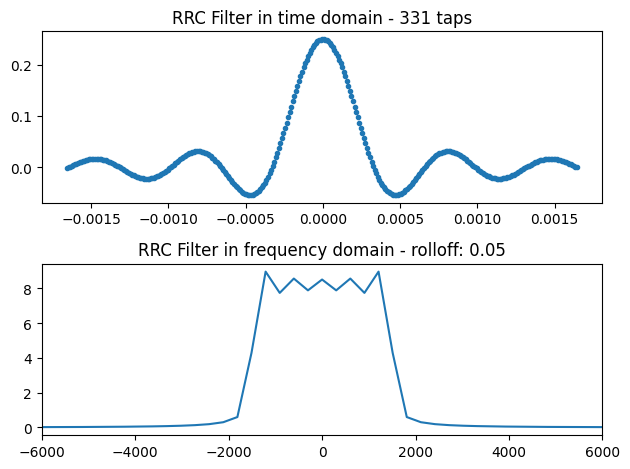

In [178]:
# define rrc pulse
beta = 0.05
alpha = 1 - beta
# N_taps = round(sps*(2+alpha))+1
N_taps = 10*sps + 1
pulse_t, pulse = cp.rrcosfilter(N_taps, beta, symbol_period, Fs)
DeltaT = pulse_t[1] - pulse_t[0]
pulse = pulse / np.sqrt(0.5*np.sum(pulse**2)) # normalize pulse's energy

# test some rect filter
# pulse_t, pulse = cp.rectfilter(N_taps, symbol_period, Fs)
# pulse = pulse / np.sqrt(np.sum(pulse**2))

fig, axs = plt.subplots(2, 1, tight_layout=True)
axs[0].plot(pulse_t, pulse, '.')
axs[0].set_title(f"RRC Filter in time domain - {N_taps} taps")

axs[1].plot(np.fft.fftshift(np.fft.fftfreq(len(pulse), DeltaT)), np.fft.fftshift(np.abs(np.fft.fft(pulse))))
axs[1].set_xlim([-2*symbol_rate, 2*symbol_rate])
axs[1].set_title(f"RRC Filter in frequency domain - rolloff: {beta}")

plt.show()

# Modulator

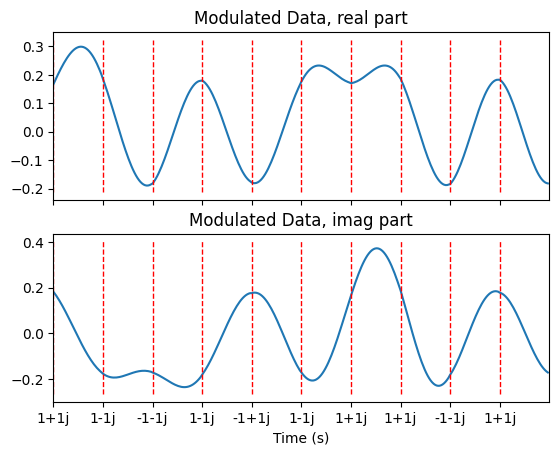

In [179]:
# modulate data
t = np.arange(0, len(upsampled)/Fs, 1/Fs)
shaped = np.convolve(upsampled, pulse, mode='same')

fig, axs = plt.subplots(2, 1, sharex=True)
start = 100*sps
end = 110*sps
axs[0].plot(t[start:end], shaped.real[start:end])
ymin, ymax = axs[0].get_ylim()
axs[0].vlines(t[start:end:sps], ymin=ymin, ymax=ymax, linestyle='--', color='r', linewidth=1)
axs[0].set_title("Modulated Data, real part")

axs[1].plot(t[start:end], shaped.imag[start:end])
ymin, ymax = axs[1].get_ylim()
axs[1].vlines(t[start:end:sps], ymin=ymin, ymax=ymax, linestyle='--', color='r', linewidth=1)
axs[1].set_title("Modulated Data, imag part")
axs[1].set_xlabel("Time (s)")

new_ticks = t[start:end:sps]
axs[1].set_xticks(new_ticks, [f"{symbols_data[start//sps:end//sps][i]:.0f}" for i in range(len(new_ticks))])

axs[0].set_xlim([t[start], t[end]])
axs[1].set_xlim([t[start], t[end]])

plt.show()

# Transmitter

## Design the transmitted signal

Note the channel's gain $a$ could be $a>1$ to emulate an amplifier

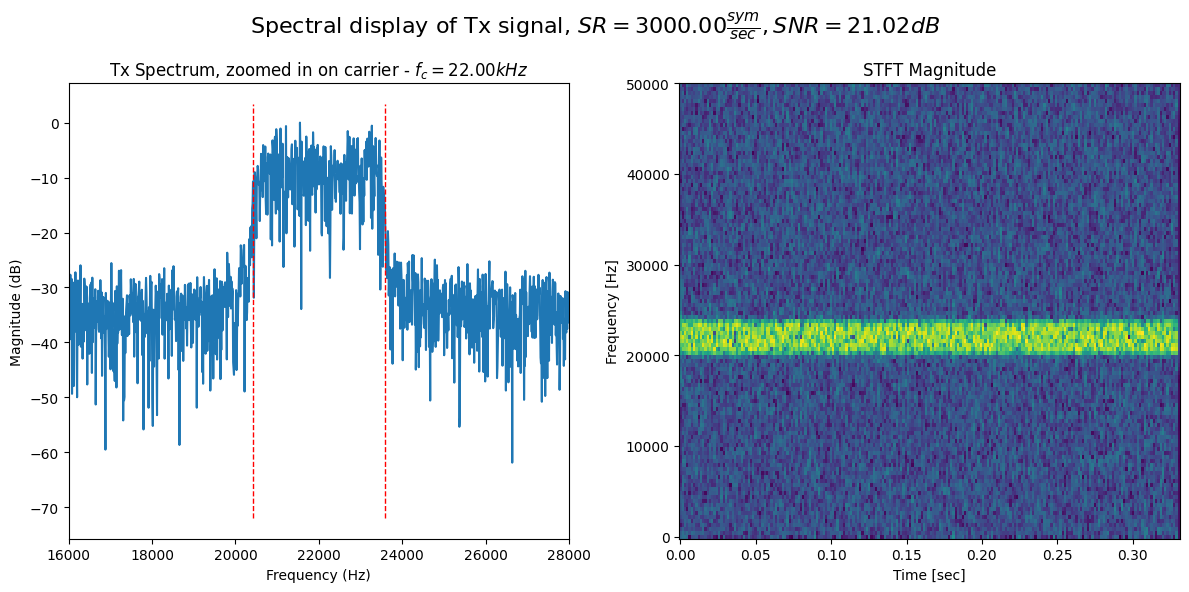

In [177]:
a = 0.7
a = 0.8
noise_a = 0.1
noise_std = 0.3

# design tx
fc = 22e3
tx = a*np.real(shaped*np.exp(1j*2*np.pi*fc*t)) + noise_a*np.random.normal(0, noise_std, len(shaped))

N = 300 # symbols to take into account for fft

X = np.fft.fftshift(np.fft.fft(tx[sps:int(N*sps)]))
freqs = np.fft.fftshift(np.fft.fftfreq(len(X), 1/Fs))

P = 20*np.log10(np.abs(X[len(X)//2:]) / np.abs(X).max())
freqs = freqs[len(X)//2:]

res = 2000
df = res*fc/Fs
nfft = int(Fs/df)
f_spec,t_spec,Zxx = signal.stft(tx, fs=Fs, nperseg=round(nfft), noverlap=round(nfft/3), nfft=nfft)
indx_fc = round(fc/df)
indx_noise = round(indx_fc - (1+beta)*symbol_rate/df)
Pxx = 20*np.log10(np.abs(Zxx)+0.001)
signal_power = Pxx[indx_fc].sum()/t_spec.size
noise_power = Pxx[indx_noise].sum()/t_spec.size
snr = signal_power-noise_power # in dB

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].plot(freqs, P)
axs[0].set_xlim([fc-2*symbol_rate, fc+2*symbol_rate])
#axs[0].set_ylim([-2*snr, 10])
ymin, ymax = axs[0].get_ylim()
axs[0].vlines([fc-0.5*(1+beta)*symbol_rate,fc+0.5*(1+beta)*symbol_rate], ymin, ymax, linestyles='dashed', colors=['r'], linewidth=1)
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude (dB)")
axs[0].set_title("Tx Spectrum, zoomed in on carrier - $f_c={:.2f}kHz$".format(fc/1e3))

axs[1].pcolormesh(t_spec, f_spec, Pxx)
axs[1].set_title('STFT Magnitude')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')

fig.suptitle("Spectral display of Tx signal, $SR={:.2f}\\frac{{sym}}{{sec}}, SNR={:.2f}dB$".format(symbol_rate,snr), fontsize=16)
fig.set_size_inches(12, 6)
plt.show()

## Symbols in the transmitted signal

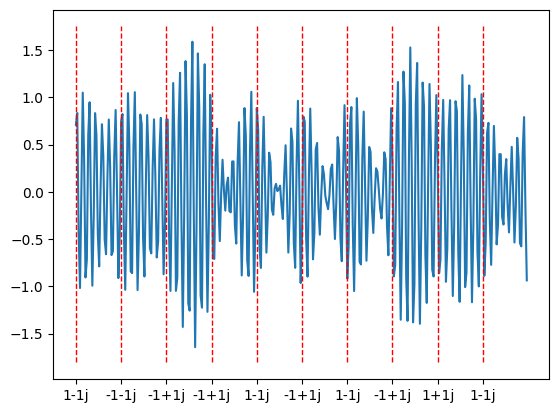

In [163]:
start_symbol = 300
end_symbol = 310
plt.plot(t[start_symbol*sps:end_symbol*sps], tx[start_symbol*sps:end_symbol*sps])
new_ticks = t[start_symbol*sps:end_symbol*sps:sps]

plt.xticks(new_ticks, [f"{symbols_data[start_symbol:end_symbol][i]:.0f}" for i in range(len(new_ticks))])
ymin, ymax = plt.ylim()
plt.vlines(new_ticks, ymin=ymin, ymax=ymax, linestyle='--', color='r', linewidth=1)
plt.show()

# Receiver

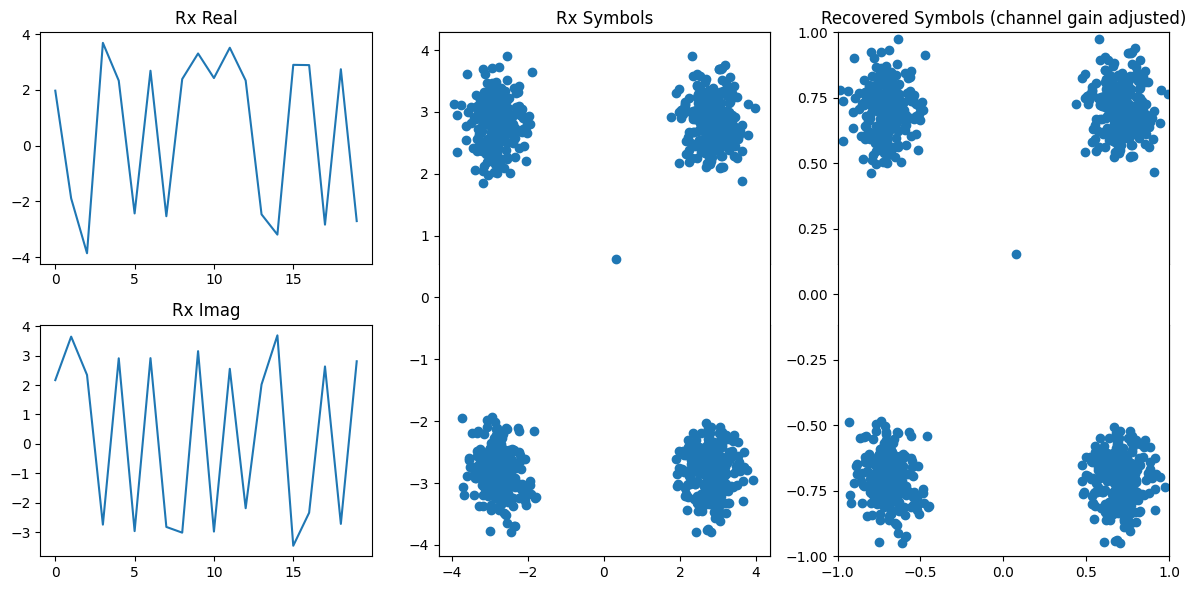

In [174]:
# get matched filter of pulse
matched_pulse = pulse.copy()
matched_pulse = matched_pulse[::-1]
matched_pulse = np.roll(matched_pulse, sps)

rx_real = tx*np.cos(2*np.pi*fc*t)
rx_imag = -1*tx*np.sin(2*np.pi*fc*t)

# apply matched filter on rx to prepare for sampling on symbol period
rx_real_LPF = np.convolve(rx_real, matched_pulse, mode='same')
rx_imag_LPF = np.convolve(rx_imag, matched_pulse, mode='same')

rx_sampled_real = rx_real_LPF[::sps]
rx_sampled_imag = rx_imag_LPF[::sps]
rx_data = rx_sampled_real + 1j*rx_sampled_imag

# fix channel attenuation
recovered_symbols = rx_data/a

fig, axs = plt.subplots(2, 3, tight_layout=True)
axs = axs.ravel()
axs[0].plot(rx_sampled_real[sps:sps+20])
axs[0].set_title("Rx Real")

axs[3].plot(rx_sampled_imag[sps:sps+20])
axs[3].set_title("Rx Imag")

ax = fig.add_subplot(132)
ax.scatter(rx_data.real, rx_data.imag)
#ax.set_xlim([-1, 1])
#ax.set_ylim([-1, 1])
ax.set_title("Rx Symbols")

ax = fig.add_subplot(133)
ax.scatter(recovered_symbols.real, recovered_symbols.imag)
ax.set_title("Recovered Symbols (channel gain adjusted)")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])


axs[1].set_yticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[4].set_yticks([])
axs[4].set_xticks([])
axs[5].set_yticks([])
axs[5].set_xticks([])
fig.set_size_inches(12, 6)
plt.show()

# Demodulator

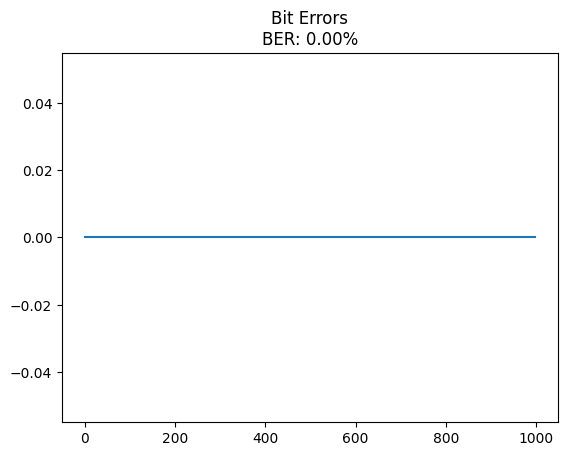

In [175]:
# recover original data
demodulated = np.zeros(len(recovered_symbols), dtype=complex)
thresh = np.abs(symbols).mean()/bits_per_symbol
for symbol in symbols:
    demodulated[np.abs(recovered_symbols - symbol) < thresh] = symbol

offset = 1
demodulated_chopped = demodulated[offset:]
data_chopped = symbols_data[:len(demodulated_chopped)]

fig, ax = plt.subplots(1, 1)
ax.plot(np.abs(demodulated[offset:] - symbols_data[:len(demodulated[offset:])]))
ax.set_title("Bit Errors\nBER: {:.2f}%".format(100*np.sum(np.abs(demodulated_chopped - data_chopped) > 0)/len(demodulated_chopped)))
plt.show()